## Traffic Sign Writeup

Here is a summary of start of journey to create a deep learning pipeline to recognize the German traffic sign

### Data Set Summary & Exploration

After we download dataset from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip) first I need to make sure I understand the data properly before I build CNN architecture

#### Basic sumarry of data


In [21]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
from sklearn.utils import shuffle
import cv2
import os
%matplotlib inline

training_file = "data_set/train.p"
validation_file= "data_set/valid.p"
testing_file = "data_set/test.p"
dt = pd.read_csv('signnames.csv').T.to_dict()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train = train['features'], train['labels']
X_valid_raw, y_valid = valid['features'], valid['labels']
X_test_raw, y_test = test['features'], test['labels']

n_train = len(X_train_raw)
n_validation = len(X_valid_raw)
n_test = len(X_test_raw)
image_shape = X_train_raw[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### let visualize sample of the images

It's always a good practice to get to know the data before we start to jump into the problem we try to solve here.

Let Randomly pick up 6 images

1 Speed limit (80km/h)
2 Speed limit (50km/h)
3 No passing for vehicles over 3.5 metric tons
4 Speed limit (100km/h)
5 Speed limit (80km/h)
6 Wild animals crossing


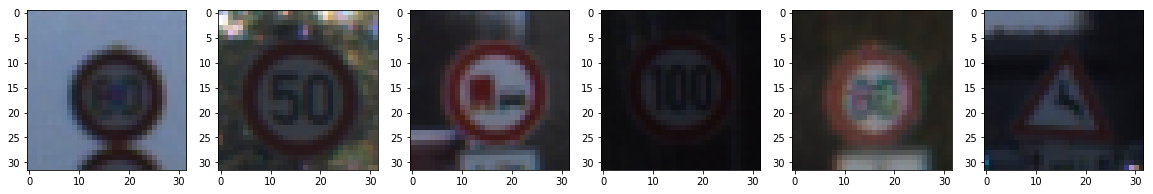

In [10]:
fig = plt.figure(figsize=(20,20))
for i in range(6):
    index = random.randint(0, len(X_train_raw))
    image = X_train_raw[index]
    ax = fig.add_subplot(1,6, i+1)
    ax.imshow(image)
    print(i+1, dt[y_train[index]]['SignName'])

### Pre-process the Data Set

We have done couple of techniques here
1. I shuffle the data so we don't get order of data set to have impact on our model
2. Apply grayscale because color doesn't play an important role to recognize the sign
3. The last one, I normalize the data set in the range of -1 to 1.


#### Apply Greyscale

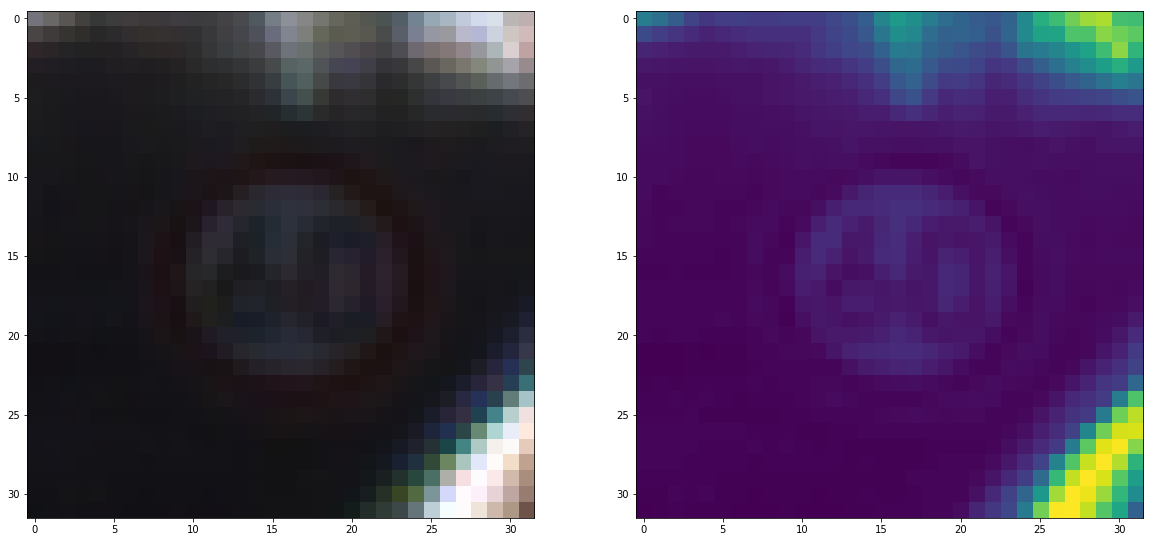

In [16]:
def _convert_to_gray(image):
    return (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

fig = plt.figure(figsize=(20,20))
index = random.randint(0, len(X_train_raw))
image = X_train_raw[index]
ax = fig.add_subplot(1,2, 1)
ax.imshow(image)
ax = fig.add_subplot(1,2, 2)
ax.imshow(_convert_to_gray(image))

#### Apply normalization

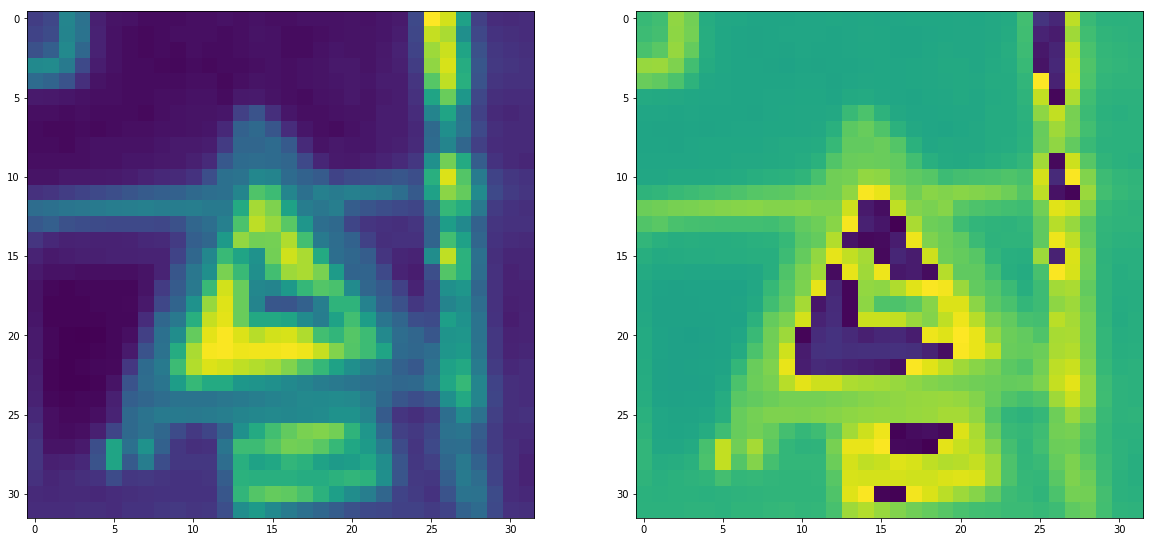

In [18]:
def _normalize(image):
    norm = (image-128)/128
    return (np.array(norm))

fig = plt.figure(figsize=(20,20))
index = random.randint(0, len(X_train_raw))
image = X_train_raw[index]
ax = fig.add_subplot(1,2,1)
ax.imshow(_convert_to_gray(image))
ax = fig.add_subplot(1,2,2)
ax.imshow(_normalize(_convert_to_gray(image)))

At the end, we apply the same pipeline to all images so our training, validation and test dataset are in the same preprocessing and I make sure our data shape is (?, 32, 32, 1) so we can feed into our model. 

### Model Architecture

Defining archictecture, I mostly pick LeNet as starting point and made some changes and adjust some of hyperparameters.

1. Input Layer 32 x 32 x 1
2. Convolution 5 x 5 with 1 stride, padding is valid and output 28x28x12
3. Activation function with a rectified linear unit (Relu)
4. Max pooling 2x2 and output 14x14x12
5. Dropout 
6. Convolution 5 x 5 with 1 stride, padding is valid and output 10x10x48
7. Activation function with a rectified linear unit (Relu)
8. Max pooling 2x2 and output 5x5x48
9. Dropout 
10. Flatten 5x5x48 and output is 1200
11. Fully Connect and output 120
12. Activation function with a rectified linear unit (Relu)
13. Dropout 
11. Fully Connect and output 120
12. Activation function with a rectified linear unit (Relu)
13. Dropout 
14. Fully Connect and output 43 

In [19]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,12), 
                                              mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], 
                         padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], 
                           strides=[1,2,2,1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob)

    #Layer 2: Convolutional. Output = 10x10x48.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,12,48), 
                                              mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], 
                         padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], 
                           padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)

    #Flatten. Input = 5x5x16. Output = 1200.
    fc0 = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 1200. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(1200, 120), 
                                            mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    
    #Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), 
                                            mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    
    #Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    #Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), 
                                            mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

### Train the model

I choose to the hot-encoding label of 0-43 signs to a vector of all zero and one only the number it represents which will match our logit out size 43.

For training technique, I use LeNet as starting point and hasn't changed the core of it because the framework is already proved itself very good in classifying images. For loss function because it's classification of multiple classes I choose `softmax_cross_entropy_with_logits` and optimizer as `AdmaOptimizer`

Hyperparameter as follow
EPOCHS = 10
BATCH SIZE = 128
LEARNING RATE = 0.001
KEEP DROPOUT RATIO = 0.8 

#### My final model results were:

* training set accuracy of 0.995
* validation set accuracy of 0.941
* test set accuracy of 0.933

#### Problem

Before getting to the last accuracy, I have tried several approaches 
1. Without pre-processing dataset, I found that the accuracy was very low so I started applying normalization to the data set with input 32x32x3 and still not passing 0.9 accuracy rate. Lastly, I found out that by converting the image to grayscale and normalization gave me a very good result.
2. I updated LeNet by adding more features in Convolution network and Fully connected layer while it improving the training set accuracy of almost 0.99 but validation and test set accuracy was lower to 0.8. Therefore it's a sign of overfitting or my model start remembers not learn from it I then added a Dropout to the model with keep probability of 0.8 and 1.0 on validation. The last result is the one shows here.

### Test a Model on the New Images

I download random download 6 German traffic signs from the internet as the example below. 

There are cropped out only the traffic sign part of the whole picture which I have to make sure I resized the image into the same shape as my model will accept as 32x32 also I noticed that the training data having a sign in the middle of the picture and not stretch to the whole 32x32 size. In order to make my new images look similar to the training set, I need to add a border of size 5 pixel as shown below.

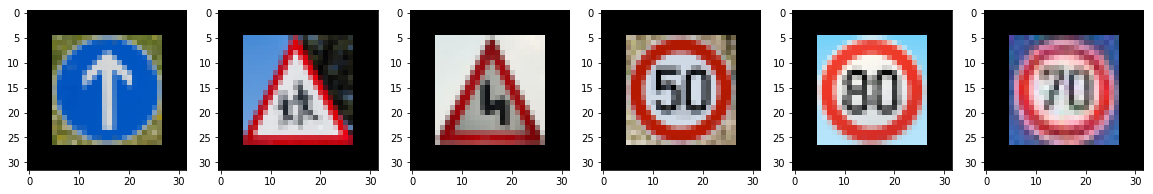

In [23]:
# intialize our new 
X_new = np.empty((6, 32, 32, 3), dtype=np.uint8)
y_new = np.array([5, 21, 28, 2, 4, 35])

sample_image_from_web_dir = 'sample_signs_from_web/' 
images = [image for image 
          in os.listdir(sample_image_from_web_dir) if '.jpeg' in image]
fig = plt.figure(figsize=(20,20))
for i, img_path in enumerate(images):
    image = cv2.imread(sample_image_from_web_dir + img_path)
    image = cv2.resize(image, (22, 22), interpolation = cv2.INTER_AREA)
    bordersize = 5
    image = cv2.copyMakeBorder(image, top=bordersize, bottom=bordersize, \
                              left=bordersize, right=bordersize, \
                              borderType= cv2.BORDER_CONSTANT, \
                              value=[0,0,0] )
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_new[i] = image
    
    ax = fig.add_subplot(1,6, i+1)
    ax.imshow(image)

#### The prediction

1. Ahead only 
2. Wild animals crossing (Incorrect it shoudl be Children crossing) 
3. Beware of ice/snow (Incorrect it should be Double curve)  
4. Speed limit (50km/h) 
5. Speed limit (80km/h) 
6. Speed limit (70km/h) 

So the overall accuracy of 6 new images are 0.667

#### Output Top 5 Softmax

After running model on saved session and run command `tf.nn.top_k(logits, k=5)` here is a result

```
TopKV2(values=array([
       [ 33.50083542,  10.69670486,   8.00453568,   6.98770809,
          5.26984787]       
       [ 22.22780991,  19.56116486,  19.30787849,   8.26754475,
          5.76795626],
       [  9.16888809,   8.9222126 ,   7.33911514,   5.54286194,
          5.46348286],
       [ 25.70634651,  13.73163986,  10.47708702,   8.48512459,
          2.80376911],
       [ 14.67648506,  13.1070919 ,  10.37863159,   6.52824783,
          5.67628336],
       [ 19.15659714,  10.90990162,   9.63236332,   5.35422754,      4.0059123 ]], dtype=float32), indices=array([
       [35, 36,  3, 33, 34],
       [30, 28, 11, 24, 23],
       [31, 21, 25, 19, 29],
       [ 2,  5,  1,  3, 31],
       [ 5,  1,  2,  7,  4],
       [ 4,  0,  1,  5,  8],], dtype=int32))
```

Let look at above probability and it's classification one by one

##### The first picture
The prediction is correct

* Ahead only with 33.5%
* Go straight or right with 10.7% 
* Speed limit (60km/h) with 8% 
* Turn right ahead with 7% 
* Turn left ahead 5%

##### The second picture
The prediction is incorrect, it should classify as Children crossing

* Beware of ice/snow with 22.22%
* Children crossing with 19.56%
* Right-of-way at the next intersection 19.30%
* Road narrows on the right 8.26%
* Slippery road 5.76%
As you can see, the model misclassify this and the correct one is just 2-3 % probability from the correct sign.

##### The third picture
The prediction is incorrect, it should classify as Double curve

* Wild animals crossing with 9.16%
* Double curve with 8.92%
* Road work with 7.33%
* Dangerous curve to the left with 5.54%
* Bicycles crossing'with 5.46%
As you can see, the model misclassify this and the correct one is just 0.24% probability from the correct sign.

##### The forth picture
The prediction is correct

* Speed limit (50km/h) with 25.7%
* Speed limit (80km/h) with 13.73%
* Speed limit (30km/h) with 10.47%
* Speed limit (60km/h) with 8.48%
* Wild animals crossing' with 2.8%

##### The fifth picture
The prediction is correct

* Speed limit (80km/h) with 14.67%
* Speed limit (30km/h) with 13.10%
* Speed limit (50km/h) with 10.37%
* Speed limit (100km/h) with 6.5%
* Speed limit (70km/h) with 5.67%

Be noticed here that 80 and 30 speed sign is almost misclassified and from what I can see number 8 and 3 are very similar.

##### The sixth picture
The prediction is correct

* Speed limit (70km/h) with 19.15%
* Speed limit (20km/h) with 11%
* Speed limit (30km/h) with 9.6%
* Speed limit (80km/h) with 5.35%
* Speed limit (120km/h) with 4%